In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, LSTM, Activation, Flatten, Dropout, SimpleRNN, Bidirectional, Conv1D, GRU, Input, BatchNormalization
from keras.models import Model
from keras.initializers import he_normal
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
import fix_yahoo_finance as yf
from stockstats import StockDataFrame
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
def OBV(data):
    last_obv = 0
    obv = [last_obv]
    for i in range(1,len(data)):
        if data['Close'][i] >= data['Close'][i-1]:
            obv.append(last_obv + data['Volume'][i])
        else:
            obv.append(last_obv - data['Volume'][i])
        last_obv = obv[-1]
    return pd.DataFrame(obv, columns=['OBV'])
def Bias(data, period=6):
    MA = data['Close'].rolling(window=period).mean()
    bias=[]
    for i in range(len(data)):
        bias.append(((data['Close'][i]-MA[i])/MA[i])*100)
    return pd.DataFrame(bias, columns=['Bias'])
def PSY(data, period=12):
    psy = [np.nan]*(period-1)
    for i in range(len(data)-period+1):
        diff = np.ediff1d(data['Close'][i:i+period])
        psy.append((len(diff[diff>=0])/len(diff))*100)
    return pd.DataFrame(psy, columns=['PSY'])
def SY(data, i, p):
    return ((data['Close'][i-p]-data['Close'][i-p-1])/data['Close'][i-p-1])*100

def ASY(data, period):
    if period == 1:
        asy = [np.nan]*2
        for i in range(2,len(data)):
            asy.append(((data['Close'][i-1]-data['Close'][i-2])/data['Close'][i-2])*100)
    else:
        asy = [np.nan]*period
        for i in range(period,len(data)):
            A=0
            for j in range(period):
                A = A + SY(data, i,j)
            A = A/(j+1)
            asy.append(A)
            
    return pd.DataFrame(asy, columns=['ASY'+str(period)])

In [4]:
def data_prepare(Stock):
    df=pd.read_csv(Stock+'.csv')
    data=df
    data['Close'].replace(0, np.nan, inplace=True)
    data['Close'].fillna(method='ffill', inplace=True)
#     indicators = ['close_50_sma','close_150_sma','close_20_ema','close_40_ema','boll','boll_ub','boll_lb',\
#              'macd','kdjk','kdjd','kdjj','atr','adx','vr','rsi_14']
#     for i in indicators:
#         df = StockDataFrame.retype(data)
#         df = df.get(i)
    data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    #values = data[2:]
    values = data[['Open'] + ['High'] + ['Low'] + ['Close'] + ['Volume']]
    values.insert(5,'OBV',OBV(data))
    values.insert(6,'MA5',data['Close'].rolling(window=5).mean())
    values.insert(7,'Bias',Bias(data,6))
    values.insert(8,'PSY12',PSY(data,12))
    values.insert(9,'ASY1',ASY(data,1))
    values.insert(10,'ASY2',ASY(data,2))
    values.insert(11,'ASY3',ASY(data,3))
    values.insert(12,'ASY4',ASY(data,4))
    values.insert(13,'ASY5',ASY(data,5))
    diff = np.ediff1d(data['Close'])
    diff=np.append(np.array([0]),diff)
    values.insert(14,'diff',diff)
    values.dropna(inplace=True)
    values = values.astype('float32')
    values = values.values 
    #values = values[~np.isnan(values).any(axis=1)]
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()
    #scaler = Normalizer()
    scaler.fit(values)
    scaled = scaler.transform(values)
    #scaled = normalize(values)
    return scaled

def data_gen(scaled, seq_len, status1, status2, end):
    scaled2=scaled
    scaled=scaled[:-end]
    if status2 == 'timeseriesgen':
        data_gen = TimeseriesGenerator(scaled[:,:-1], scaled[:,-1],
                                       length=seq_len, sampling_rate=1,
                                       stride=1, batch_size=len(scaled))
        X, y = data_gen[0]
        print(X.shape, y.shape)
#         y = np.ediff1d(scaled[:,3])
#         print(y.shape)
#         data_gen = TimeseriesGenerator(y, y,
#                                        length=seq_len, sampling_rate=1,
#                                        stride=1, batch_size=len(y))
#         y_seq,_ = data_gen[0]
#         print(y_seq.shape)
#         y=y_seq
#         X = X[:-1]
#         print(X.shape, y.shape)
#         if status1 == 'classification':
#             y1 = np.empty([len(y),y.shape[1]], dtype=np.float32)
#             for i in range(len(y)):
#                 for j in range(y.shape[1]):
#                     if y[i,j] >= 0:
#                         y1[i,j] = 1.0
#                     else:
#                         y1[i,j] = 0.0
#             y1=y1[:,-1]
#             print(X.shape, y1.shape)
#         else:
#             y1 = np.empty([len(y),y.shape[1]], dtype=np.float32)
#             for i in range(len(y)):
#                 for j in range(y.shape[1]):
#                     if y[i,j] >= 0:
#                         y1[i,j] = 1.0
#                     else:
#                         y1[i,j] = -1.0
#            #y1 = y
#             y1=y1[:,-1]
#             print(X.shape, y1.shape)
#         X, y1 = shuffle(X, y1, random_state = 0)
#         train_X = X[:-seq_len]
#         train_y = y1[:-seq_len]
#         test_X = X[-seq_len:]
#         test_y = y1[-seq_len:]
        y1=y
        scaler = StandardScaler()
        train_X = X[:-seq_len]
        train_y = y1[:-seq_len]
        train_X, train_y = shuffle(train_X, train_y, random_state = 0)
        test_X = X[-seq_len:]
        test_y = y1[-seq_len:]
    else:
        X = scaled[-(seq_len+1):-1,:].reshape(1,seq_len,56)
        y = scaled[-1,-1]-scaled[-2,-1]
        for i in range(1,4127):
            X = np.append(X, scaled[-(seq_len+1)-i:-1-i,:].reshape(1,seq_len,56),axis=0)
            y = np.append(y, scaled[-1-i,3]-scaled[-2-i,3])
        if status1 == 'classification':
            y1 = np.empty([len(y)], dtype=np.float32)
            for i in range(len(y)):
                if y[i] >= 0.0:
                    y1[i] = 1.0
                else:
                    y1[i] = 0.0
            print(X.shape,y.shape)
            scaler = StandardScaler()
        else:
            y1 = np.empty([len(y)], dtype=np.float32)
            for i in range(len(y)):
                if y[i] >= 0.0:
                    y1[i] = 1.0
                else:
                    y1[i] = -1.0
            #y1 = y
            #print(X.shape, y1.shape)
            #scaler = MinMaxScaler(feature_range=(-1, 1))
            #y1=y
            scaler = StandardScaler()
            #scaler = Normalizer()
            #scaler.fit(y1.reshape(-1,1))
            #y1 = scaler.transform(y1.reshape(-1,1))
            #y1 = normalize(y1)
        X, y1 = shuffle(X, y1, random_state = 0)
        train_X = X
        train_y = y1
        test_X = X[-seq_len:]
        test_y = y1[-seq_len:]
    return scaler, scaled2, scaled, train_X, train_y, test_X, test_y

def tcn(h,filters=400, kernel_size=3, padding='causal', activation='relu', dilation_rate=1):
    main = BatchNormalization()(h)
    main = h
    init = he_normal(seed=1)
    for i in range(2):
        main = Conv1D(filters=filters,kernel_size=kernel_size,padding=padding, dilation_rate=dilation_rate, kernel_initializer=init)(main)
        main = Activation('relu')(main)
        main = BatchNormalization()(main)
        main = Dropout(0.15)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same', kernel_initializer=init)(h)
    side_path = BatchNormalization()(side_path)
    return Add()([main,side_path])

def MODEL(status):
    # status: either "classification" or "regression"
    Inp = Input(shape=(15,14))
    inp = Inp
    D = [1,1,1,1,1]
    for i in range(3):
        inp=tcn(inp,dilation_rate=D[i])
        inp = BatchNormalization()(inp)
        #inp = Activation('relu')(inp)
    inp=Flatten()(inp)
    init = he_normal(seed=1)
    inp=Dense(100, activation='selu',kernel_initializer=init)(inp)
    inp = BatchNormalization()(inp)
    #inp = Activation('selu')(inp)
    inp = Dropout(0.45)(inp)
    inp=Dense(20, activation='selu', kernel_initializer=init)(inp)
    inp = BatchNormalization()(inp)
    #inp = Activation('selu')(inp)
    inp = Dropout(0.25)(inp)
    if status == 'classification':
        out=Dense(1,activation='sigmoid', kernel_initializer=init)(inp)
    else:
        out=Dense(1)(inp)
    model = Model(Inp,out)
    return model

def train_model(model, train_X, train_y, status):
    ad = optimizers.Adam(lr=0.0008)
    if status == 'classification':
        model.compile(loss='binary_crossentropy', optimizer=ad)
    else: 
        model.compile(loss='mse', optimizer=ad)
    history = model.fit(train_X, train_y, epochs=10, batch_size=128, verbose=1, validation_split=0.1, shuffle=False)
    return model, history

def plot_loss(history):
    pyplot.plot(history.history['loss'], label='multi_train')
    pyplot.plot(history.history['val_loss'], label='multi_test')
    pyplot.legend()
    pyplot.yscale('log')
    pyplot.show()

def acc(model, scaled2, status, seq_len, end, scaler):
    pred = model.predict(scaled2[-(seq_len+end):-end,:-1].reshape(1,seq_len,14))[0][-1]
    #y_test = scaled2[-end,3]-scaled2[-end-1,3]
    y_test = scaled2[-end,-1]
    #pred = scaler.inverse_transform(pred)
    #y_test = scaler.transform(y_test)
    print('prediction', pred, 'y_test', y_test)
#     for i in range(1,seq_len):
#         pred = np.append(pred, np.array([model.predict(scaled2[-(seq_len+1)-i:-1-i,:].reshape(1,seq_len,56))[0][-1]]))
#         y_test = np.append(y_test, scaled2[-1-i,3]-scaled2[-2-i,3])
    p=np.empty(1) 
    if status == "classification":
        T = 0.5
    else:
        T = 0.0
    for i in range(1):
        if pred >= T:
            p = +1.0
        else:
            p = -1.0
    mul = np.multiply(p, y_test)
    return mul #len(mul[mul>=0])/len(mul)

def test_acc(model, test_X, test_y, status):
    pred = model.predict(test_X)
    p=np.empty([len(pred)])
    y_test=np.empty([len(pred)])
    if status == "classification":
        T = 0.5
    else:
        T = 0.0
    for i in range(len(pred)):
        if pred[i,-1] >= T:
            p[i] = +1.0
        else:
            p[i] = -1.0
        if test_y[i] >= T:
            y_test[i] = 1.0
        else:
            y_test[i] = -1.0
    mul = np.multiply(p, y_test)
    return len(mul[mul>=0])/len(mul)

In [25]:
stocks=['OI','NI','UPS','HSIC','CCE','IBM','MAS','EFX','AAPL','WDC']
status1='classification'
status2='timeseriesgen'
accuracy=np.empty((19,0))


test_accuracy=pd.DataFrame()
for Stock in stocks:
    Mul=np.empty((0,1))
    scaled = data_prepare(Stock)
    scaler, scaled2, scaled, train_X, train_y, test_X, test_y = data_gen(scaled, 15, status1, status2, 20)
    model = MODEL(status1)
    #model.load_weights(Stock+status2+'_'+status1+'.h5')
    model, history = train_model(model, train_X, train_y,status1)
    #plot_loss(history)
    model.save_weights(Stock+status2+'_'+status1+'.h5')
    for end in range(1,20):
        mul = acc(model, scaled2,status1, 15, end, scaler)
        Mul = np.append(Mul,[[mul]],axis=0)
    accuracy = np.append(accuracy, Mul, axis=1)
    #model_test_accuracy = test_acc(model, test_X, test_y,status1)
    #print(Stock+' accuracy', mul)
    #print(Stock +' test_accuracy', model_test_accuracy) 
    #test_accuracy = test_accuracy.append(pd.DataFrame([[Stock, model_test_accuracy]]),ignore_index=True)
#Mul=np.array(Mul)
#accuracy = accuracy.append(pd.DataFrame([[str(end), len(Mul[Mul>=0])/len(Mul)]]),ignore_index=True)
#accuracy.columns=['Stock','accuracy']
#test_accuracy.columns=['Stock','test_accuracy']
Accuracy = pd.DataFrame(accuracy)
Accuracy.columns = stocks

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(4251, 15, 14) (4251,)
Train on 3812 samples, validate on 424 samples
Epoch 1/10
3812/3812 [==============================] - 20s 5ms/step - loss: 2.4169 - val_loss: 1.2166
Epoch 2/10
3812/3812 [==============================] - 4s 964us/step - loss: 1.7248 - val_loss: 1.0079
Epoch 3/10
3812/3812 [==============================] - 4s 975us/step - loss: 1.6437 - val_loss: 1.0189
Epoch 4/10
3812/3812 [==============================] - 4s 978us/step - loss: 1.5864 - val_loss: 0.9730
Epoch 5/10
3812/3812 [==============================] - 4s 962us/step - loss: 1.5262 - val_loss: 0.9948
Epoch 6/10
3812/3812 [==============================] - 4s 982us/step - loss: 1.4409 - val_loss: 0.9487
Epoch 7/10
3812/3812 [==============================] - 4s 974us/step - loss: 1.3636 - val_loss: 0.9684
Epoch 8/10
3812/3812 [==============================] - 4s 964us/step - loss: 1.3298 - val_loss: 0.9450
Epoch 9/10
3812/3812 [==============================] - 4s 981us/step - loss: 1.2796 - val_loss: 0.

3807/3807 [==============================] - 28s 7ms/step - loss: 1.9620 - val_loss: 1.0091
Epoch 2/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.5325 - val_loss: 0.9835
Epoch 3/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.5043 - val_loss: 0.9034
Epoch 4/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.3898 - val_loss: 0.8902
Epoch 5/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.3764 - val_loss: 0.8993
Epoch 6/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.3239 - val_loss: 0.9011
Epoch 7/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.2658 - val_loss: 0.9068
Epoch 8/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.2169 - val_loss: 0.8921
Epoch 9/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.1806 - val_loss: 0.8927
Epoch 10/10
3807/3807 [==============================] - 4s 1ms/step - loss: 1.1591 - val_lo

In [26]:
Accuracy

,OI,NI,UPS,HSIC,CCE,IBM,MAS,EFX,AAPL,WDC
0,-0.173054,-1.290853,0.555273,-0.863849,-1.002730,1.638692,-0.015072,-0.677670,5.693126,-0.808344
1,-0.817457,1.561382,-0.807345,-1.720293,0.345989,-2.662752,-1.268738,0.394633,10.164231,-1.291137
2,0.745228,1.417632,-0.568103,1.587920,0.524498,-0.577031,-0.383793,-0.320234,0.302293,-0.219335
3,-2.525143,-0.910554,1.210569,-0.964601,-0.090364,1.118677,-1.489971,0.849557,-1.018076,-0.524164
4,-0.398595,0.276723,0.035183,1.336024,-0.645716,0.253858,0.796127,0.405467,-2.985014,-1.069049
5,0.390805,-0.023197,-0.235252,0.108171,0.583996,0.316043,-0.752512,1.716071,-0.599202,0.630379
6,0.004160,-0.530262,-1.400227,0.292895,-0.249032,-0.848342,0.034091,0.145516,1.613590,0.620720
7,-0.140832,0.864161,8.054819,-2.158888,-0.249040,-0.124840,2.148132,-0.006123,-1.222020,-1.841521
8,-0.318043,-1.117706,-0.297660,0.781853,0.921182,-0.175719,0.378235,-0.081950,0.111074,0.369674
9,0.455244,5.220614,0.648882,-0.830256,-0.487040,-1.074441,-0.752524,-1.370879,0.444401,1.673213


In [27]:
r=[]
A = Accuracy
for i in range(A.shape[1]):
    m = A.iloc[:,i]
    r.append(len(m[m>-0.0])/len(m))
A=A.append(pd.DataFrame([r], columns=stocks))
r=[]
for i in range(A.shape[0]):
    m = A.iloc[i,:]
    r.append(len(m[m>-0.0])/len(m))
A['Accuracy'] = r
A

,OI,NI,UPS,HSIC,CCE,IBM,MAS,EFX,AAPL,WDC,Accuracy
0,-0.173054,-1.290853,0.555273,-0.863849,-1.002730,1.638692,-0.015072,-0.677670,5.693126,-0.808344,0.3
1,-0.817457,1.561382,-0.807345,-1.720293,0.345989,-2.662752,-1.268738,0.394633,10.164231,-1.291137,0.4
2,0.745228,1.417632,-0.568103,1.587920,0.524498,-0.577031,-0.383793,-0.320234,0.302293,-0.219335,0.5
3,-2.525143,-0.910554,1.210569,-0.964601,-0.090364,1.118677,-1.489971,0.849557,-1.018076,-0.524164,0.3
4,-0.398595,0.276723,0.035183,1.336024,-0.645716,0.253858,0.796127,0.405467,-2.985014,-1.069049,0.6
5,0.390805,-0.023197,-0.235252,0.108171,0.583996,0.316043,-0.752512,1.716071,-0.599202,0.630379,0.6
6,0.004160,-0.530262,-1.400227,0.292895,-0.249032,-0.848342,0.034091,0.145516,1.613590,0.620720,0.6
7,-0.140832,0.864161,8.054819,-2.158888,-0.249040,-0.124840,2.148132,-0.006123,-1.222020,-1.841521,0.3
8,-0.318043,-1.117706,-0.297660,0.781853,0.921182,-0.175719,0.378235,-0.081950,0.111074,0.369674,0.5
9,0.455244,5.220614,0.648882,-0.830256,-0.487040,-1.074441,-0.752524,-1.370879,0.444401,1.673213,0.5


In [13]:
r=[]
A = Accuracy
for i in range(A.shape[1]):
    m = A.iloc[:,i]
    r.append(len(m[m>-0.0])/len(m))
A=A.append(pd.DataFrame([r], columns=stocks))
r=[]
for i in range(A.shape[0]):
    m = A.iloc[i,:]
    r.append(len(m[m>-0.0])/len(m))
A['Accuracy'] = r
A

,OI,NI,UPS,HSIC,CCE,IBM,MAS,EFX,AAPL,WDC,Accuracy
0,-0.173054,1.290853,0.555273,0.863849,1.002730,-1.638692,0.015072,-0.677670,-5.693126,-0.808344,0.5
1,-0.817457,-1.561382,-0.807345,-1.720293,0.345989,2.662752,1.268738,0.394633,-10.164231,-1.291137,0.4
2,0.745228,1.417632,-0.568103,1.587920,0.524498,0.577031,0.383793,-0.320234,-0.302293,-0.219335,0.6
3,2.525143,0.910554,-1.210569,0.964601,-0.090364,-1.118677,1.489971,0.849557,1.018076,-0.524164,0.6
4,0.398595,0.276723,0.035183,-1.336024,0.645716,-0.253858,-0.796127,-0.405467,2.985014,1.069049,0.6
5,0.390805,0.023197,-0.235252,0.108171,-0.583996,-0.316043,0.752512,-1.716071,0.599202,-0.630379,0.5
6,-0.004160,0.530262,-1.400227,0.292895,0.249032,0.848342,-0.034091,-0.145516,-1.613590,-0.620720,0.4
7,0.140832,-0.864161,8.054819,-2.158888,0.249040,0.124840,-2.148132,-0.006123,-1.222020,1.841521,0.5
8,-0.318043,-1.117706,-0.297660,-0.781853,-0.921182,-0.175719,-0.378235,-0.081950,-0.111074,-0.369674,0.0
9,0.455244,5.220614,0.648882,0.830256,0.487040,-1.074441,0.752524,-1.370879,0.444401,-1.673213,0.7


In [9]:
accuracy.shape

(50, 0)

In [17]:
test=np.empty((4,0))
test = np.append(test,np.array([[1],[2],[3],[4]]),axis=1)
test = np.append(test,np.array([[5],[6],[7],[8]]),axis=1)
test

array([[ 1.,  5.],
       [ 2.,  6.],
       [ 3.,  7.],
       [ 4.,  8.]])

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(4198, 44, 14) (4198,)
(4193, 44, 14) (4193,)
(4136, 44, 14) (4136,)
(4193, 44, 14) (4193,)
(4198, 44, 14) (4198,)
(4193, 44, 14) (4193,)
(4193, 44, 14) (4193,)
(4193, 44, 14) (4193,)
(4202, 44, 14) (4202,)
(4193, 44, 14) (4193,)
Train on 37306 samples, validate on 4146 samples
Epoch 1/50
37306/37306 [==============================] - 80s 2ms/step - loss: 1.3774 - val_loss: 0.9745
Epoch 2/50
37306/37306 [==============================] - 74s 2ms/step - loss: 1.0848 - val_loss: 0.9785
Epoch 3/50
37306/37306 [==============================] - 75s 2ms/step - loss: 1.0220 - val_loss: 0.9648
Epoch 4/50
37306/37306 [==============================] - 74s 2ms/step - loss: 1.0000 - val_loss: 0.9608
Epoch 5/50
37306/37306 [==============================] - 74s 2ms/step - loss: 0.9866 - val_loss: 0.9623
Epoch 6/50
37306/37306 [==============================] - 72s 2ms/step - loss: 0.9842 - val_loss: 0.9607
Epoch 7/50
37306/37306 [==============================] - 72s 2ms/step - loss: 0.9785 - val

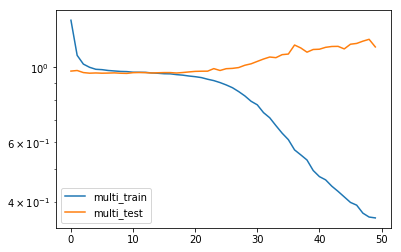

WDC test_accuracy 0.4818181818181818


In [13]:
stocks=['OI','NI','UPS','HSIC','CCE','IBM','MAS','EFX','AAPL','WDC']
trainX=np.empty((0,44,14))
trainy=np.empty((0,))
testX=np.empty((0,44,14))
testy=np.empty((0,))
Scaled2={}
status1='reg'
status2= 'timeseriesgen'
for Stock in stocks:
    scaled = data_prepare(Stock)
    scaled2, scaled, train_X, train_y, test_X, test_y = data_gen(scaled, 44, status1, status2, 44)
    trainX = np.append(trainX, train_X, axis=0)
    trainy = np.append(trainy, train_y.reshape(-1), axis=0)
    testX = np.append(testX, test_X, axis=0)
    testy = np.append(testy, test_y.reshape(-1), axis=0)
    Scaled2[Stock] = scaled2
model = MODEL(status1)
model, history = train_model(model, trainX, trainy,status1)
plot_loss(history)
model.save_weights(Stock+status2+'_'+status1+'.h5')
# for scaled2 in Scaled2:
#     model_accuracy = acc(model, Scaled2[scaled2],status1, 44)
#     print(scaled2+' accuracy', model_accuracy)
model_test_accuracy = test_acc(model, testX, testy,status1)
print(Stock +' test_accuracy', model_test_accuracy)
  

In [28]:
for scaled2 in Scaled2:
    model_accuracy = acc(model, Scaled2[scaled2],status1, 15)
    print(scaled2+' accuracy', model_accuracy)
model_test_accuracy = test_acc(model, testX, testy,status1)
print(Stock +' test_accuracy', model_test_accuracy)

OI accuracy 0.4
NI accuracy 0.6
UPS accuracy 0.6
HSIC accuracy 0.6666666666666666
CCE accuracy 0.5333333333333333
IBM accuracy 0.6
MAS accuracy 0.6
EFX accuracy 0.4666666666666667
AAPL accuracy 0.6
WDC accuracy 0.6
WDC test_accuracy 0.8866666666666667


In [23]:
accuracy = train(stocks, 'reg', 'scaled2')

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(4127, 15, 56) (4127,)
Train on 3714 samples, validate on 413 samples
Epoch 1/2
3714/3714 [==============================] - 9s 2ms/step - loss: 6.6482 - val_loss: 1.5815
Epoch 2/2
3714/3714 [==============================] - 4s 956us/step - loss: 3.9093 - val_loss: 1.3367
OI accuracy -0.00195905602995
(4127, 15, 56) (4127,)
Train on 3714 samples, validate on 413 samples
Epoch 1/2
3714/3714 [==============================] - 9s 2ms/step - loss: 8.3682 - val_loss: 1.6051
Epoch 2/2
3714/3714 [==============================] - 3s 935us/step - loss: 3.4188 - val_loss: 0.3667
NI accuracy 0.00816602727034
(4127, 15, 56) (4127,)
Train on 3714 samples, validate on 413 samples
Epoch 1/2
3714/3714 [==============================] - 11s 3ms/step - loss: 3.4832 - val_loss: 0.4290
Epoch 2/2
3714/3714 [==============================] - 4s 952us/step - loss: 1.9429 - val_loss: 0.2691
UPS accuracy 0.00574176863165
(4127, 15, 56) (4127,)
Train on 3714 samples, validate on 413 samples
Epoch 1/2
3714/371

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements